In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import seaborn as sns
import sys
import scipy.stats as sc
import pandas as pd
import ffl

sys.path.append('../External_Functions')
from ExternalFunctions import UnbinnedLH, Chi2Regression, BinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax  # Useful functions to print fit results on figure

sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('deep', 10, desat = 1)
sns.set_palette(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams['figure.figsize'] = (16, 9)


c:\Users\Niels\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# 4.1 The file www.nbi.dk/∼petersen/data LargestPopulation.csv contains data on the Indian and Chinese population each year in the period 1960-2021.

## 4.1.1 Linearly fit the Indian population 1963-1973, and estimate the data point uncertainty.



In [2]:
dataframe = pd.read_csv('data_LargestPopulation.csv', header=0)
year, PopIndia, PopChina = dataframe.values.T
dataframe

for i in range(10):
    print(f"  Year: {int(year[i]):4d}   PopIndia = {PopIndia[i]:9.0f}   PopChina = {PopChina[i]:9.0f}")

  Year: 1960   PopIndia = 445954560   PopChina = 654170700
  Year: 1961   PopIndia = 456351870   PopChina = 655260350
  Year: 1962   PopIndia = 467024200   PopChina = 664614660
  Year: 1963   PopIndia = 477933630   PopChina = 683903550
  Year: 1964   PopIndia = 489059300   PopChina = 704593800
  Year: 1965   PopIndia = 500114340   PopChina = 723846340
  Year: 1966   PopIndia = 510992600   PopChina = 742948540
  Year: 1967   PopIndia = 521987070   PopChina = 761006300
  Year: 1968   PopIndia = 533431900   PopChina = 780372000
  Year: 1969   PopIndia = 545314700   PopChina = 801431000


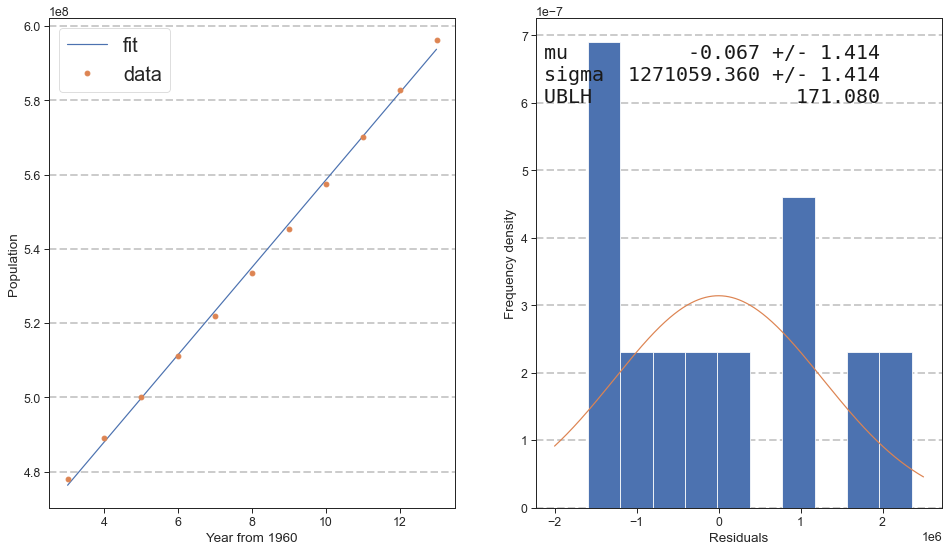

In [3]:
# DATA START YEAR = 1960
start_year = year.min()
year = year - start_year


mask_1963_1973 = (year <= 13) & (year >= 3)
india_1963_1973 = PopIndia[mask_1963_1973]
year_1963_1973 = year[mask_1963_1973]

def lin(x, a, b):
    return a*x + b

#fit without errors using curve_fit
from scipy.optimize import curve_fit

par_ini, cov_ini = curve_fit(lin, year_1963_1973, india_1963_1973, p0 = [1, 1])

def gauss_ublh(x, mu, sigma, ):
    return sc.norm.pdf(x, mu, sigma)




x_fit = np.linspace(year_1963_1973.min(), year_1963_1973.max(), 1000)
y_fit = lin(x_fit, *par_ini)

residuals = india_1963_1973 - lin(year_1963_1973, *par_ini)
UBLH_val, UBLH_dict = ffl.UBLH_minuit(gauss_ublh, residuals, [np.mean(residuals), np.std(residuals)])

fig , ax = plt.subplots(1, 2)
ax[0].plot(x_fit, y_fit, label = 'fit')
ax[0].plot(year_1963_1973, india_1963_1973, 'o', label = 'data')
ax[0].legend(fontsize=20)
ax[0].set_xlabel('Year from 1960')
ax[0].set_ylabel('Population')

nice_string = nice_string_output(UBLH_dict, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, nice_string, ax[1], fontsize=20)
ax[1].hist(residuals, bins = 10, label = 'residuals', density=True)
x_plot_new = np.linspace(-0.2*10e6, 0.25*10e6, 1000)
ax[1].plot(x_plot_new, gauss_ublh(x_plot_new, *UBLH_val.values[:]), label = 'fit')

ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Frequency density')

plt.savefig('saved_images/4_1_1_1')

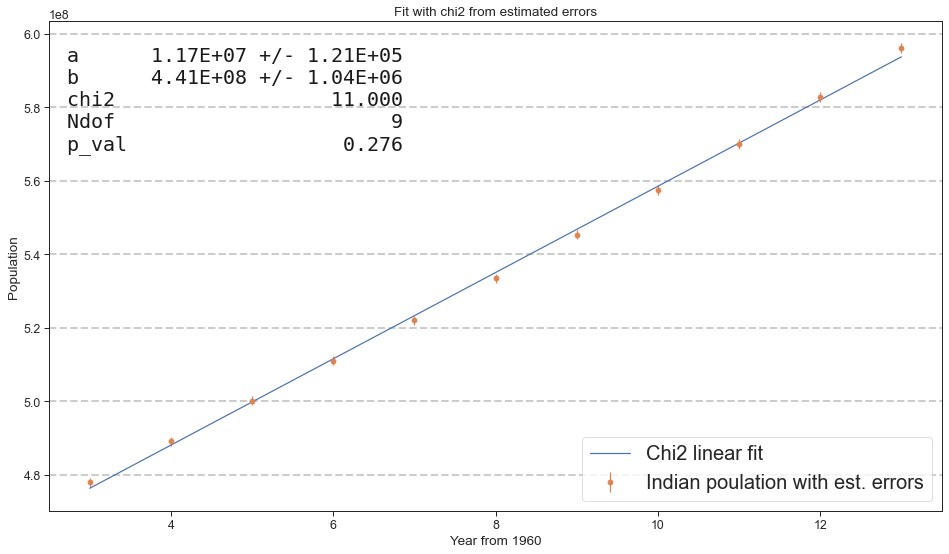

In [4]:
estimated_err = UBLH_val.values['sigma']
fit_par, N_dof, p_val, minuit_dict = ffl.fit_with_chi2(lin, year_1963_1973, india_1963_1973, estimated_err, [par_ini[0], par_ini[1]])

#format a and b to scietific notation
a = fit_par.values['a']
b = fit_par.values['b']
a_err = fit_par.errors['a']
b_err = fit_par.errors['b']
a = '{:.2E}'.format(a)
b = '{:.2E}'.format(b)
a_err = '{:.2E}'.format(a_err)
b_err = '{:.2E}'.format(b_err)
# update dict
minuit_dict['a'] = [a, a_err]
minuit_dict['b'] = [b, b_err]


fig, ax = plt.subplots()
good_string = nice_string_output(minuit_dict, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, good_string, ax, fontsize=20)
ax.plot(x_fit, lin(x_fit, *fit_par.values[:]), label = 'Chi2 linear fit')
ax.errorbar(year_1963_1973, india_1963_1973, yerr=estimated_err, marker ='o', ls='None', label = 'Indian poulation with est. errors')
ax.set_xlabel('Year from 1960')
ax.set_ylabel('Population')
ax.legend(fontsize=20, loc='lower right')
ax.set_title('Fit with chi2 from estimated errors')

plt.savefig('saved_images/4_1_1_2')

## 4.1.2 Assuming an uncertainty of ±1000000 on all data points, model the population developments and give your best estimate of when the Indian population overtakes the Chinese.


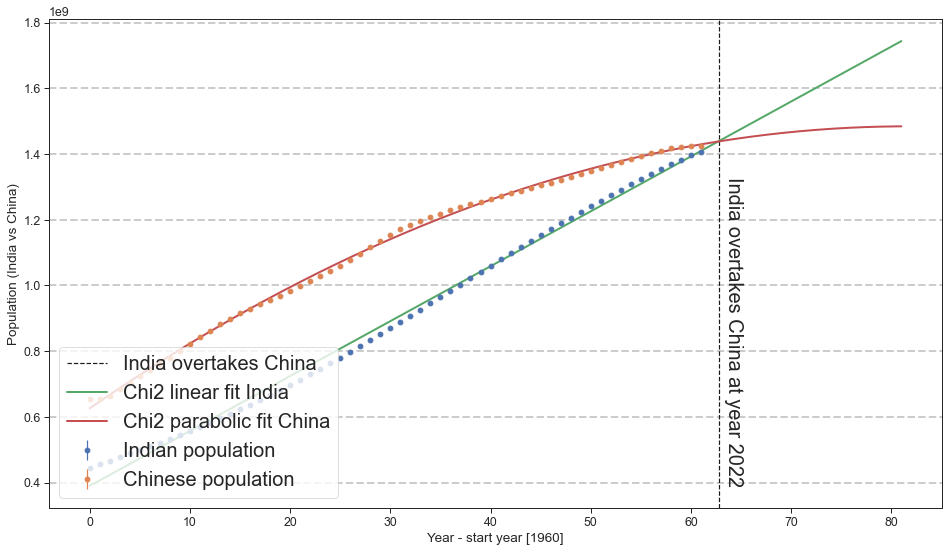

In [5]:
new_err = np.ones(len(PopChina)) * 1000000

year_new = year.copy()

fig, ax = plt.subplots()
ax.errorbar(year_new, PopIndia, yerr=new_err, marker='o', ls='', label = 'Indian population')
ax.errorbar(year_new, PopChina, yerr=new_err, marker='o', ls='', label = 'Chinese population')
ax.set_xlabel('Year - start year [1960]')
ax.set_ylabel('Population (India vs China)')


def parabola(x, a, b, c):
    return a*x**2 + b*x + c




chi2_india, N_dof_india, p_val_india, minuit_dict_india = ffl.fit_with_chi2(lin, year_new, PopIndia, new_err, [1,1])
chi2_china, N_dof_china, p_val_china, minuit_dict_china = ffl.fit_with_chi2(parabola, year_new, PopChina, new_err, [1,1,1])


x_plot = np.linspace(year_new.min(), year_new.max() + 20 , 1000)
y_plot_india = lin(x_plot, *chi2_india.values[:])
y_plot_china = parabola(x_plot, *chi2_china.values[:])

# Find intersection of fits

intersect = np.where( y_plot_india > y_plot_china)[0][0]
x_intersect = x_plot[intersect]


ax.axvline(x_intersect, color='k', ls='--', label = 'India overtakes China')
ax.text(x_intersect + 0.5, 0.4*1e9, f'India overtakes China at year {int(x_intersect + start_year)}', rotation = 270,  fontsize=20)
ax.plot(x_plot, y_plot_india, label = 'Chi2 linear fit India', linewidth=2)
ax.plot(x_plot, y_plot_china, label = 'Chi2 parabolic fit China', linewidth=2)
string_india = nice_string_output(minuit_dict_india, extra_spacing=2, decimals=3)
string_china = nice_string_output(minuit_dict_china, extra_spacing=2, decimals=3)


ax.legend(fontsize=20, loc='lower left')

plt.savefig('saved_images/4_1_2')